
Adaptive
+--------------+---------+----------+----------+--------------------+--------------+---------------+-----------+----------+-------------+------------+
| Block Name   |   In_Ch |   Out_Ch |   Stride |   Expansion Factor | Input Size   | Output Size   |      MACs |   Params |   Precision |     BitOps |
+==============+=========+==========+==========+====================+==============+===============+===========+==========+=============+============+
| Block_0      |      32 |       16 |        1 |                  1 | 224x224      | 224x224       |  40140800 |      800 |           8 | 2569011200 |
+--------------+---------+----------+----------+--------------------+--------------+---------------+-----------+----------+-------------+------------+
| Block_1      |      16 |       24 |        2 |                  6 | 224x224      | 112x112       | 116809728 |     4704 |           4 | 1868955648 |
+--------------+---------+----------+----------+--------------------+--------------+

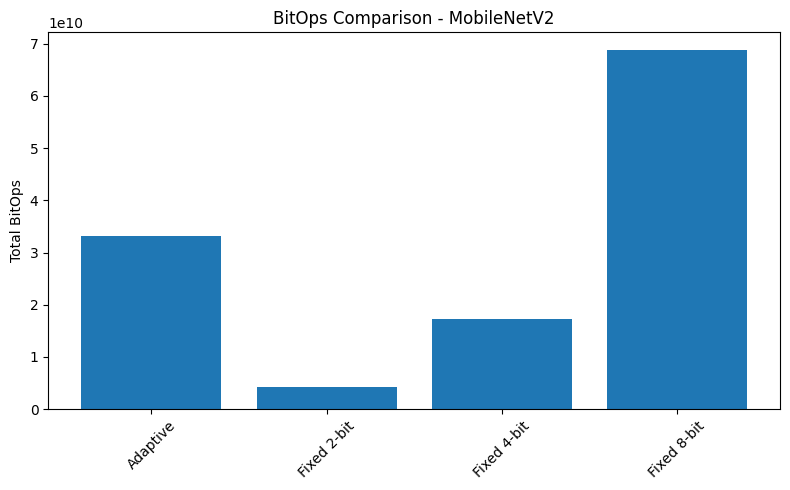

In [1]:
import math
import torch
import torch.nn as nn
import torchvision.models as models
from tabulate import tabulate
import matplotlib.pyplot as plt
import csv
import os

# Compute output dimensions after convolution based on stride
def compute_output_dim(input_dim, stride):
    return math.ceil(input_dim / stride)

# Assign precision adaptively based on the MAC ratio of each block
def get_mac_based_precision(block, total_macs):
    mac_ratio = block.macs / total_macs
    if mac_ratio > 0.15:
        return 2
    elif mac_ratio > 0.05:
        return 4
    else:
        return 8

# Represents a single inverted residual block in MobileNetV2
class InvertedResidualBlock:
    def __init__(self, name, in_ch, out_ch, stride, expansion_factor, input_h, input_w):
        self.name = name
        self.in_ch = in_ch
        self.out_ch = out_ch
        self.stride = stride
        self.expansion_factor = expansion_factor
        self.input_h = input_h
        self.input_w = input_w

        self.expanded_ch = in_ch * expansion_factor
        self.out_h = compute_output_dim(input_h, stride)
        self.out_w = compute_output_dim(input_w, stride)

        self.macs, self.params = self.calculate_macs_and_params()
        self.precision = 8                                                      # Default precision (can be overwritten later)

    # Calculate total MACs and parameters for this block
    def calculate_macs_and_params(self):
        macs = 0
        params = 0

        # Expansion phase (1x1 conv)
        if self.expansion_factor != 1:
            expansion_macs = self.input_h * self.input_w * self.in_ch * self.expanded_ch
            expansion_params = self.in_ch * self.expanded_ch
            macs += expansion_macs
            params += expansion_params

        # Depthwise conv (3x3)
        depthwise_macs = self.out_h * self.out_w * self.expanded_ch * 9
        depthwise_params = self.expanded_ch * 9
        macs += depthwise_macs
        params += depthwise_params

        # Projection (1x1 conv)
        projection_macs = self.out_h * self.out_w * self.expanded_ch * self.out_ch
        projection_params = self.expanded_ch * self.out_ch
        macs += projection_macs
        params += projection_params

        return macs, params

    # Assign precision to this block
    def set_precision(self, precision):
        self.precision = precision

    # Compute BitOps for this block
    def get_bitops(self):
        return self.macs * (self.precision ** 2)

    # Return a summary dictionary for this block
    def summary(self):
        return {
            "Block Name": self.name,
            "In_Ch": self.in_ch,
            "Out_Ch": self.out_ch,
            "Stride": self.stride,
            "Expansion Factor": self.expansion_factor,
            "Input Size": f"{self.input_h}x{self.input_w}",
            "Output Size": f"{self.out_h}x{self.out_w}",
            "MACs": self.macs,
            "Params": self.params,
            "Precision": self.precision,
            "BitOps": self.get_bitops()
        }

# Extract all inverted residual blocks from MobileNetV2 and assign precision
def extract_inverted_residual_blocks(input_size=(224, 224), precision_type="variable"):
    blocks = []
    height, width = input_size

    # MobileNetV2 architecture config: (t, c, n, s)
    inverted_residual_settings = [
        [1, 16, 1, 1],
        [6, 24, 2, 2],
        [6, 32, 3, 2],
        [6, 64, 4, 2],
        [6, 96, 3, 1],
        [6, 160, 3, 2],
        [6, 320, 1, 1],
    ]

    total_blocks = sum([n for _, _, n, _ in inverted_residual_settings])
    block_index = 0
    in_channels = 32
    temp_blocks = []

    # Instantiate each block using standard MobileNetV2 settings
    for t, c, n, s in inverted_residual_settings:
        for i in range(n):
            stride = s if i == 0 else 1
            block = InvertedResidualBlock(
                name=f"Block_{block_index}",
                in_ch=in_channels,
                out_ch=c,
                stride=stride,
                expansion_factor=t,
                input_h=height,
                input_w=width
            )
            temp_blocks.append(block)
            height = block.out_h
            width = block.out_w
            in_channels = c
            block_index += 1

    total_macs = sum(b.macs for b in temp_blocks)

    # Assign precision to each block (either fixed or adaptive)
    for block in temp_blocks:
        precision = get_mac_based_precision(block, total_macs) if precision_type == "variable" else precision_type
        block.set_precision(precision)

    return temp_blocks

# Summarize the architecture and optionally export results to CSV
def summarize_architecture(blocks, title, csv_path=None):
    headers = ["Block Name", "In_Ch", "Out_Ch", "Stride", "Expansion Factor",
               "Input Size", "Output Size", "MACs", "Params", "Precision", "BitOps"]

    rows, total_macs, total_params, total_bitops = [], 0, 0, 0

    for block in blocks:
        s = block.summary()
        rows.append([s[h] for h in headers])
        total_macs += s["MACs"]
        total_params += s["Params"]
        total_bitops += s["BitOps"]

    print(f"\n{title}")
    print(tabulate(rows, headers=headers, tablefmt="grid"))

    print("\nTotal Stats:")
    print(tabulate([
        ["Total MACs", total_macs],
        ["Total BitOps", total_bitops],
        ["Total Parameters", total_params]
    ], tablefmt="grid"))

    if csv_path:
        with open(csv_path, 'w', newline='') as f:
            writer = csv.writer(f)
            writer.writerow(headers)
            writer.writerows(rows)
            writer.writerow([])
            writer.writerow(["Total MACs", total_macs])
            writer.writerow(["Total BitOps", total_bitops])
            writer.writerow(["Total Parameters", total_params])

    return {"MACs": total_macs, "BitOps": total_bitops, "Params": total_params}

# Plot a bar chart comparing BitOps across quantization settings
def plot_bitops(results_dict, model_name):
    labels = list(results_dict.keys())
    bitops = [v["BitOps"] for v in results_dict.values()]

    plt.figure(figsize=(8, 5))
    plt.bar(labels, bitops)
    plt.title(f"BitOps Comparison - {model_name}")
    plt.ylabel("Total BitOps")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f"results/bitops_comparison_{model_name.lower().replace(' ', '_')}.png")
    plt.show()

# Main function to run precision experiments and summarize results
def main():
    os.makedirs("results", exist_ok=True)
    results = {}

    for precision in ["variable", 2, 4, 8]:
        label = f"Adaptive" if precision == "variable" else f"Fixed {precision}-bit"
        blocks = extract_inverted_residual_blocks(precision_type=precision)
        csv_path = os.path.join("results", f"mobilenetv2_{label.replace(' ', '_').lower()}.csv")
        results[label] = summarize_architecture(blocks, title=label, csv_path=csv_path)

    plot_bitops(results, "MobileNetV2")

if __name__ == "__main__":
    main()